In [1]:
import numpy as np
import scipy.io.wavfile
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import parse_records as pr
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [2]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
mnist = tf.contrib.learn.datasets.load_dataset("mnist")

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


In [3]:
c_labels = np.array([i for i in range(0,10)])
def plot_with_labels(lowDWeights, labels, filename='tsne.png'):
    assert lowDWeights.shape[0] >= len(labels), "More labels than weights"
    plt.figure(figsize=(10, 10))  #in inches
    for i, label in enumerate(labels):
        x, y = lowDWeights[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom'
                )

    plt.savefig(filename)

In [4]:
import tensorflow as tf
mnist = tf.contrib.learn.datasets.load_dataset("mnist")

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


In [5]:
mnist.test.labels

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

# Attempt to project just 1 image

In [6]:
weights = pr.parse_all("weights_format.txt")[0]

In [7]:
np.array(weights).shape

(100, 10)

In [8]:
pca = PCA(n_components=2)
lowDWeights = pca.fit_transform(weights)

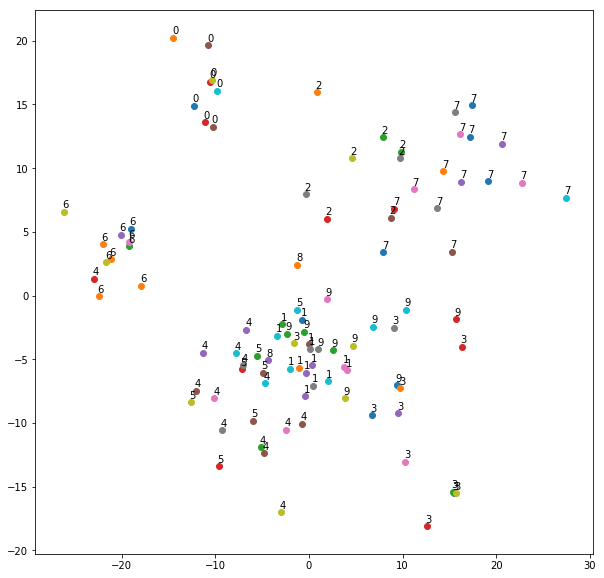

In [9]:
plot_with_labels(lowDWeights,mnist.test.labels[:100] )

# Project all images across epochs

In [10]:
all_weights = pr.parse_all("weights_format.txt")

In [11]:
np.array(all_weights).shape

(7, 100, 10)

In [12]:
epoch_weights = []

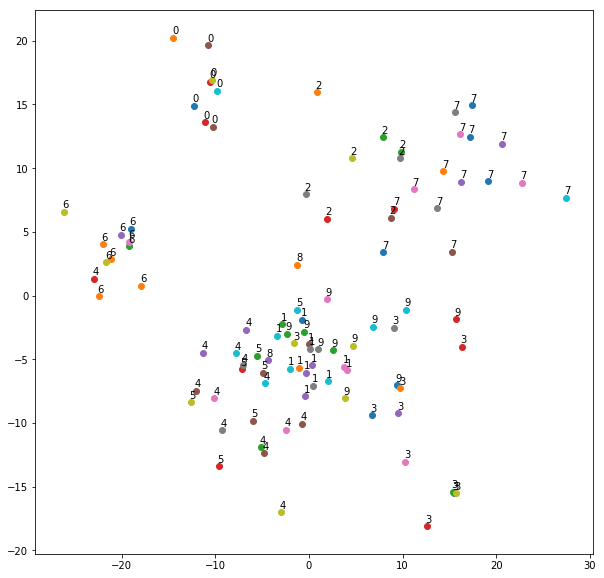

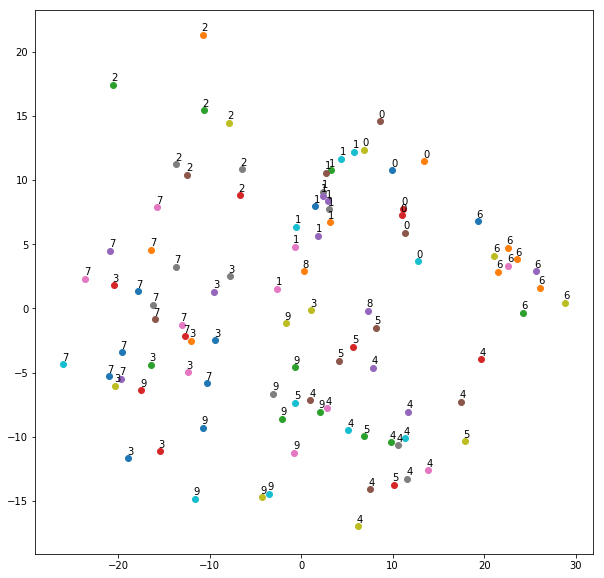

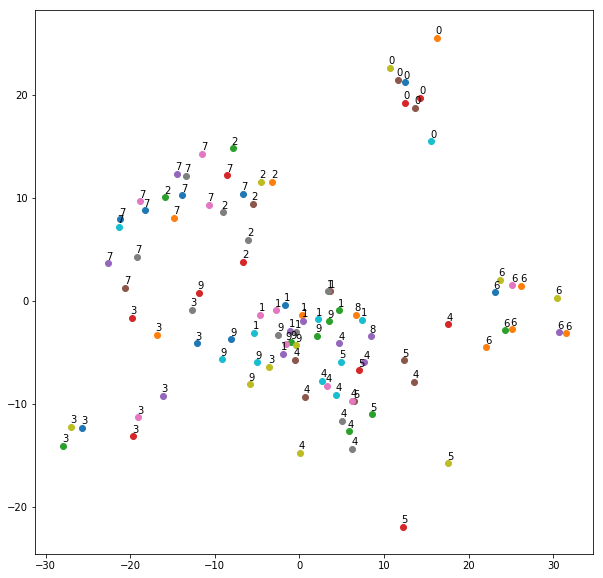

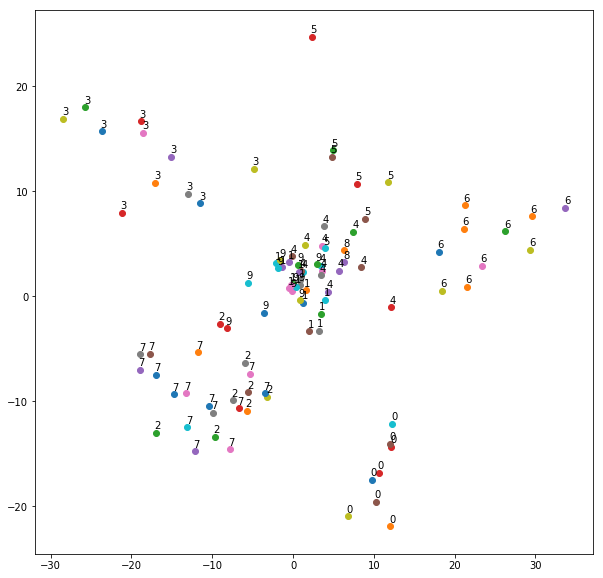

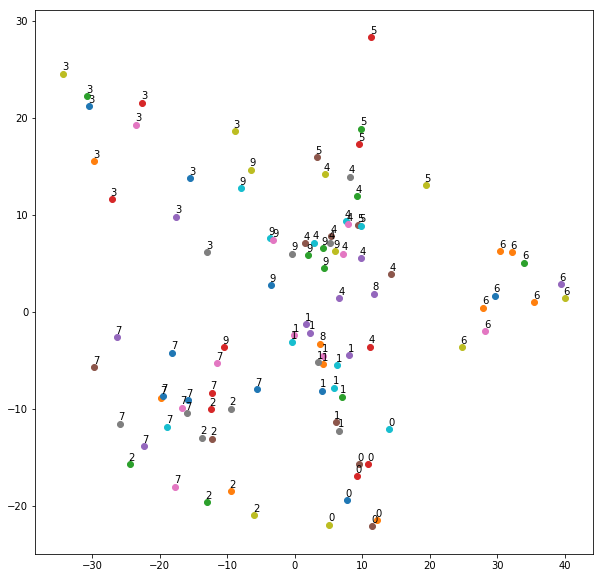

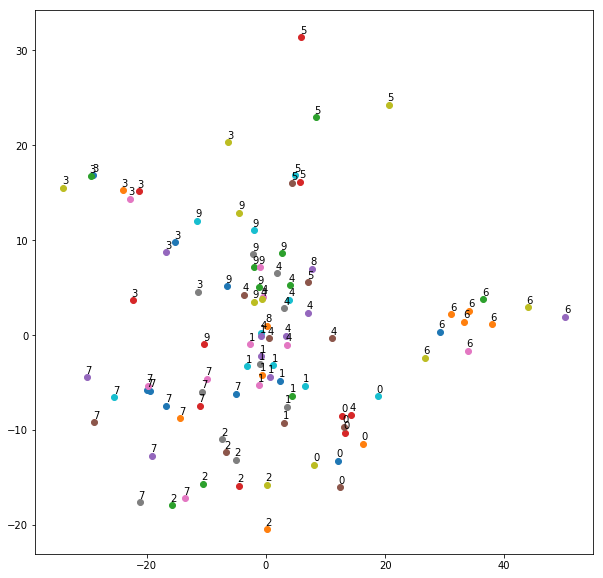

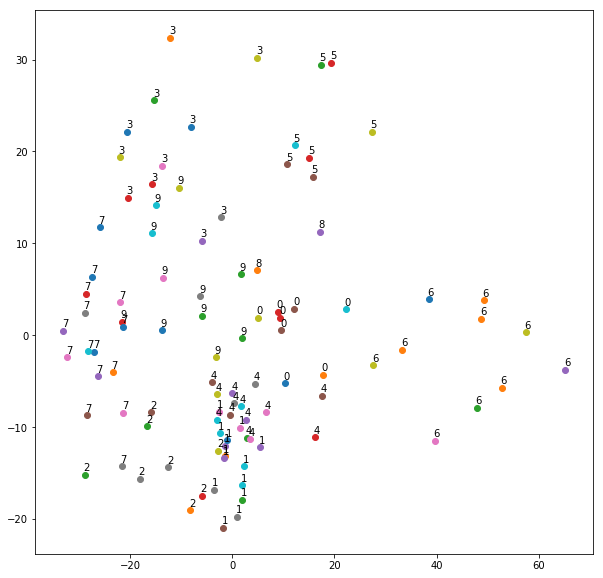

In [13]:
i=0
for w in all_weights:
    pca = PCA(n_components=2)
    lowDWeights = pca.fit_transform(w) 
    epoch_weights.append(lowDWeights)
    plot_with_labels(lowDWeights, mnist.test.labels[:100], "pca"+str(i))
    i+=1

In [14]:
#given a list of points, generates a matrix of distances 
def calc_distances(pts_lst): 
    dist_matrix = []
    for i in pts_lst: 
        pts = list(map(lambda x: np.linalg.norm(i-x), pts_lst))
        dist_matrix.append(pts)
    return np.array(dist_matrix)

In [15]:
distances = calc_distances(epoch_weights[0])

In [16]:
def kth_distances(pt_lst,k):
    sorted = np.sort(pt_lst)[1:k+1]
    pts = []
    for i in sorted: 
        pt_index = np.nonzero(pt_lst==i)
        if(len(pt_index)>1): raise Exception("same distances")
        else: pt_index = pt_index[0][0]
        pts.append({"pt":pt_index,"dist":i, "class":mnist.test.labels[pt_index]})
    return pts

In [17]:
print(mnist.test.labels[0])
pts_dict= kth_distances(distances[0], 6)

7


In [18]:
def pt_ratio(nearest, i_label):
    s = 0.0
    for i in nearest: 
        if i["class"]==i_label: s+=1
    return s / len(nearest)

def n_ratio(projs, k):
    distances = calc_distances(projs)#matrix of distances
    sum_ratios = 0.0
    for i in range(len(distances)): 
        nearest = kth_distances(distances[i], k)
        i_label = mnist.test.labels[i]
        sum_ratios += pt_ratio(nearest, i_label)
    return sum_ratios / len(distances)

In [19]:
n_ratio(epoch_weights[0],6)

0.6216666666666666

In [20]:
epoch_weights[0].shape

(100, 2)

In [21]:
for i in range(len(epoch_weights)):
    avg = 0
    for j in range(1,7):
        avg += n_ratio(epoch_weights[i],j)
    print("epoch"+str(i) + ": " +str(avg/6))

epoch0: 0.6309722222222222
epoch1: 0.6391111111111112
epoch2: 0.66
epoch3: 0.6149444444444444
epoch4: 0.7229444444444444
epoch5: 0.7493333333333333
epoch6: 0.6840833333333333


In [22]:
np.save("epoch_weights_PCA", epoch_weights)

## OK But what about alignment though

In [23]:
import alignment as al

In [24]:
source_matrix = epoch_weights[1]
target_matrix = epoch_weights[0]
print(source_matrix.shape, target_matrix.shape)

(100, 2) (100, 2)


In [25]:
source_matrix_new = al.make_transform(source_matrix, target_matrix)

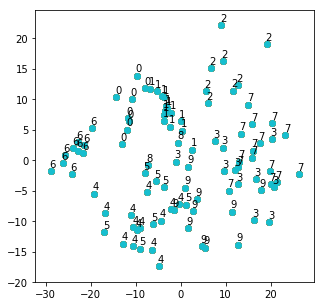

In [26]:
labels = mnist.test.labels[:100]
al.plot_with_labels(source_matrix_new, labels)

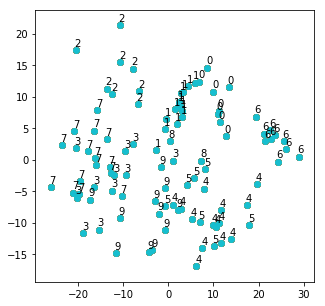

In [27]:
al.plot_with_labels(source_matrix, labels)

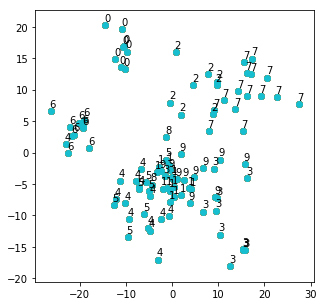

In [28]:
al.plot_with_labels(target_matrix, labels)